In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import time
import edge_detection as edge
import lane_modified

#### Loading Yolo weights, and config

In [2]:
def get_net():
    weights_path = 'yolov3.weights'
    config_path = 'yolov3.cfg'
    net = cv2.dnn.readNetFromDarknet(config_path, weights_path)
    names = net.getLayerNames()
    return net, names

In [3]:
def draw_output(indexes, boundingBoxes, objConfidences , class_IDs, frame):
    labels_path = 'coco.names'
    labels = open(labels_path).read().strip().split("\n")
    for i in indexes.flatten():
        (x,y) = [boundingBoxes[i][0],boundingBoxes[i][1]]
        (w,h) = [boundingBoxes[i][2],boundingBoxes[i][3]]

        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,165,0),2)
        cv2.putText(frame,"{}: {}".format(labels[class_IDs[i]],objConfidences[i]), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,165,0),2)
    return frame

=         TEST Images           =
straight_lines1.jpg	 straight_lines2.jpg	 test1.jpg	 test2.jpg	 

test3.jpg	 test4.jpg	 test5.jpg	 

test6.jpg	 
Select a file from the directory(q- quit): test1.jpg


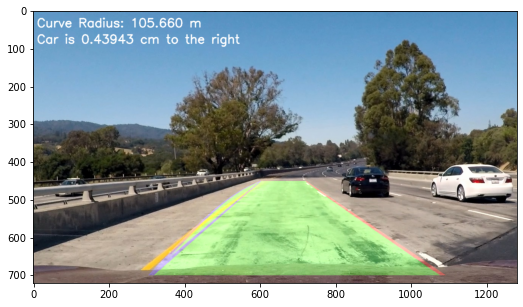

A forward pass through yolov3 took 0.49646806716918945


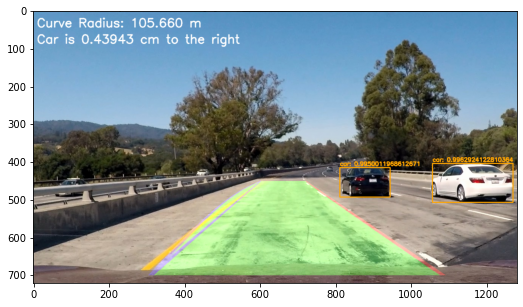

=         TEST Images           =
straight_lines1.jpg	 straight_lines2.jpg	 test1.jpg	 test2.jpg	 

test3.jpg	 test4.jpg	 test5.jpg	 

test6.jpg	 
Select a file from the directory(q- quit): test3.jpg


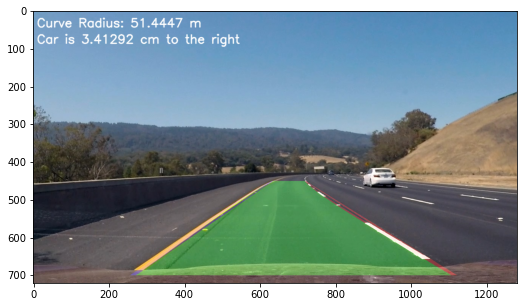

A forward pass through yolov3 took 0.502448320388794


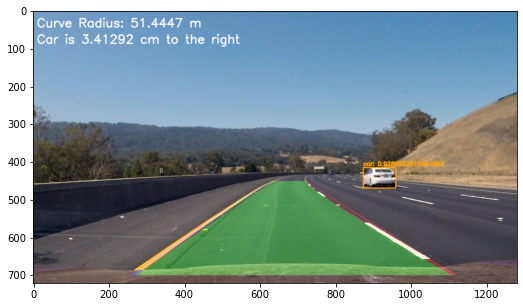

=         TEST Images           =
straight_lines1.jpg	 straight_lines2.jpg	 test1.jpg	 test2.jpg	 

test3.jpg	 test4.jpg	 test5.jpg	 

test6.jpg	 
Select a file from the directory(q- quit): q


In [4]:
while 1:
    files = os.listdir('../test_images')
    print("======================================")
    print("=         TEST Images           =")
    print("======================================")
    for i in files:
        print('{}\t '.format(i), end='')
        if files.index(i) % 3 == 0 and files.index(i) != 0:
            print('\n')
    print("\n======================================")

    # need to select image name with the extension (ex: img1.jpeg)1
    file = input("Select a file from the directory(q- quit): ").strip()
    # quit program
    if file == 'q' or file == 'Q':
        break
    image = '../test_images/' + file

    frame = cv2.imread(image)
    cv2.imshow('frame', frame)
    cv2.waitKey(0)
    lane_detecticted_img = lane_modified.lane_detection(frame)
    cv2.imshow('lane detection', lane_detecticted_img)
    cv2.waitKey(0)
    
    net, names = get_net()
    
    lane_detecticted_img = cv2.cvtColor(lane_detecticted_img, cv2.COLOR_BGR2RGB)
    plt.rcParams["figure.figsize"] = (10,5)
    plt.imshow(lane_detecticted_img)
    plt.show()

    (H,W) = lane_detecticted_img.shape[:2]
    layers_names = [names[i - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(lane_detecticted_img, 1/255.0, (416,416), crop=False, swapRB = False)
    net.setInput(blob)
    # calculate the runtime of the algorithm
    start_t = time.time()
    layers_output = net.forward(layers_names)
    print("A forward pass through yolov3 took {}".format(time.time() - start_t))

    boxes = []
    confidences = []
    classIDs = []

    for output in layers_output:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if(confidence > 0.85):
                box = detection[:4] * np.array([W,H,W,H])
                bx,by,bw,bh = box.astype("int")

                x = int(bx - (bw/2))
                y = int(by - (bh/2))

                boxes.append([x,y,int(bw),int(bh)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes,confidences,score_threshold=0.4,nms_threshold=0.6)

    output_frame = draw_output(idxs, boxes, confidences, classIDs, lane_detecticted_img)
    plt.imshow(lane_detecticted_img)
    plt.show()
    output_frame = cv2.cvtColor(output_frame ,cv2.COLOR_RGB2BGR)
    cv2.imshow("result", output_frame)
    cv2.waitKey(0)
    

    
    
    # save image containing highlighted defect
    cv2.imwrite('../output_images/{}_part2_thresholded.jpg'.format(file.split('.')[0]),output_frame)     
    # Close all windows
    cv2.destroyAllWindows()